In [523]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='id', project_access_token='token')
pc = project.project_context

project.save_data("venues_BerHa.csv", venues_BerHa_clean.to_csv(), overwrite = True)
project.save_data("different_cities_final_table.csv", merged_clean_BerHa.to_csv(), overwrite = True)

{'file_name': 'different_cities_final_table.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmdatasciencecertificationprojec-donotdelete-pr-k68zlv3eghfjhp',
 'asset_id': '1dc5a36f-1687-40ae-b9d1-2143c3b1f8f2'}

# Different cities, similar neighborhoods?

### Introduction / Scope
**Berlin and Hamburg** are Germany's two largest cities. While Berlin is counting roughtly 3.6 million inhabitants and Hamburg roughtly 1.8 million, both cities are quite different. **Berlin** is filled with an eclectic mix of history, culture and gorgeous sights, it’s a city that intrigues yet embraces visitors with open arms. The city is bursting with internationality as a result of many new residents from all over the world.
Germany’s second city, Hanseatic **Hamburg** is both typically German and unique in its own way. With a long maritime history, this North Sea port city has a distinct feel from anywhere else in the country and tons of cool things to see and do.

Both cities beeing in the northern part of Germany, there is a great exchange between residents of both cities. **This analysis is intended to show which areas of one city resemble those of the other: Berlin and Hamburg.** This could be helpfull for different use case (and therefore different stakeholders:
* *People moving from one city to the other* often would like to live in a very specific type of neighborhood. This comparisson can help those to filter for areas similar (or even different, if you are up for something new) to what you are used to.
* *Companies expanding within one of the cities* might want to look for similar type of neighborhoods, as they are targeting a specific user group. The comparisson can be used for a first indication.
* *Companies expanding from one city to the other* might also try to find a neighborhood to settle in first. They can use their experience from the original city and look for a fitting (e.g. similar) neighborhood in the second one.

                                                *Hamburg*
<a data-flickr-embed="true" href="https://www.flickr.com/photos/danczw/43628571765/in/album-72157649772585816/" title="Glossy Jungfernstieg, Hamburg, Germany"><img src="https://live.staticflickr.com/1870/43628571765_27534c8e63_w.jpg" width="400" height="203" alt="Glossy Jungfernstieg, Hamburg, Germany"></a><script async src="//embedr.flickr.com/assets/client-code.js" charset="utf-8"></script>

                                                *Berlin*
<a data-flickr-embed="true" href="https://www.flickr.com/photos/danczw/40557928022/in/album-72157649772585816/" title="Behind the Brandenburger Tor, Berlin, Germany"><img src="https://live.staticflickr.com/4625/40557928022_59d7564f6a_w.jpg" width="400" height="218" alt="Behind the Brandenburger Tor, Berlin, Germany"></a><script async src="//embedr.flickr.com/assets/client-code.js" charset="utf-8"></script>


### Data
Two different kind of data is needed for the comparison.
1. **City neighborhood and respective geographical data:** in order to analyse the cities on a meaningfull level, they need to be divided into differen areas, e.g. neighborhoods, boroughs. Luckily both is available as a Github repro and can be found [here](https://github.com/zauberware/postal-codes-json-xml-csv). This data includes 11 rows, of which only state (i.e. Berlin or Hamburg), ZIP-code (10*** for Berlin, 22*** for Hamburg), latitude and longitude per ZIP-code will be needed. ZIP-codes will be used for dividing both cities into smaller areas. ZIP-code is chosen as it is an unique identifier. In the following this data is cleaned and filtered to what is needed.

2. **Venue data:** The first 100 venues per ZIP-code in both Hamburg and Berlin are scraped in order to cluster the different areas.  This data, including the Venue name, its categroy, latitude and longitude, is gathered using the Foursquare API.

-----------------------------------------------------------------------------------------------------------------------

###### Basic data processing

First, all needed libraries are imported.

In [397]:
# importing standard libraries
import pandas as pd
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if folium is not installed
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# library to handle requests
import requests

!conda install -c conda-forge geopy --yes # uncomment this line if geopy is not installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
print('Import done!')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Import done!


Then, the basic data frame for ZIP-codes is established and filled with the pre-existing data

In [390]:
# @hidden_cell
# import csv with all german postal codes
# source: https://github.com/zauberware/postal-codes-json-xml-csv/blob/master/data/DE/zipcodes.de.csv - by simonfranzen on github
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='id',
    ibm_auth_endpoint="https://iam.eu-de.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client.get_object(Bucket='bucket',Key='zipcodes.de.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

zipcode_Ger = pd.read_csv(body)

In [391]:
print(f'Shape of basic data frame with {zipcode_Ger.shape[0]} rows (i.e. ZIP-codes) and {zipcode_Ger.shape[1]} columns, including:')
print(zipcode_Ger.dtypes)

Shape of basic data frame with 16481 rows (i.e. ZIP-codes) and 11 columns, including:
country_code       object
zipcode             int64
place              object
state              object
state_code         object
province           object
province_code       int64
community          object
community_code      int64
latitude          float64
longitude         float64
dtype: object


The imported data is filtered to include only necessary information.

In [179]:
#drop columns not needed and keep all ZIP-codes for the state of Berlin
zipcode_Ber = zipcode_Ger[['zipcode', 'state', 'latitude','longitude']].copy()
zipcode_Ber = zipcode_Ber[zipcode_Ber.state == 'Berlin']
zipcode_Ber.reset_index(drop = True, inplace = True)

zipcode_Ha = zipcode_Ger[['zipcode', 'state', 'latitude','longitude']].copy()
zipcode_Ha = zipcode_Ha[zipcode_Ha.state == 'Hamburg']
zipcode_Ha.drop_duplicates(subset=['zipcode'], keep='first', inplace = True)
zipcode_Ha.reset_index(drop = True, inplace = True)

print(f'Shape of Berlin ZIP-code only dataframe: {zipcode_Ber.shape}')

#drop columns not needed and keep all zipcodes for the state of Hamburg
zipcode_Ha = zipcode_Ger[['zipcode', 'state', 'latitude','longitude']].copy()
zipcode_Ha = zipcode_Ha[zipcode_Ha.state == 'Hamburg']
zipcode_Ha.drop_duplicates(subset=['zipcode'], keep='first', inplace = True)
zipcode_Ha.reset_index(drop = True, inplace = True)
print(f'Shape of Hamburg ZIP-code only dataframe: {zipcode_Ha.shape}')

#combine both data frames for Berlin and Hamburg
frames = [zipcode_Ber, zipcode_Ha]
zipcode_BerHa = pd.concat(frames)
zipcode_BerHa.reset_index(drop = True, inplace = True)
print(f'Shape of filtered data frame including all ZIP-codes for Berlin and Hamburg: {zipcode_BerHa.shape}')
zipcode_BerHa.head()

Shape of Berlin ZIP-code only dataframe: (195, 4)
Shape of Hamburg only ZIP-code dataframe: (101, 4)
Shape of filtered data frame including all ZIP-codes for Berlin and Hamburg: (296, 4)


,zipcode,state,latitude,longitude
0,10115,Berlin,52.5323,13.3846
1,10117,Berlin,52.5170,13.3872
2,10119,Berlin,52.5305,13.4053
3,10178,Berlin,52.5213,13.4096
4,10179,Berlin,52.5122,13.4164


---------------------
###### Data scraping
The Foursquare API is set up and run to scrape venues per ZIP-code.

In [1]:
# @hidden_cell
#utilizing the Foursquare API to explore the neighborhoods and segment them
#first, defining Foursquare Credentials and Version
CLIENT_ID = 'id' # your Foursquare ID
CLIENT_SECRET = 'secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: id
CLIENT_SECRET:secret


In [259]:
#function to retrieve first 100 avenues per ZIP-code in Berlin and Hamburg
LIMIT = 100

def getNearbyVenues(zipcode, state, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for zipcode, state, lat, lng in zip(zipcode, state, latitudes, longitudes):
        print(zipcode)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            state,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zipcode',
                  'State',
                  'Zipcode Latitude', 
                  'Zipcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#run the above function on each neighborhood and create a new dataframe called toronto_venues
venues_BerHa = getNearbyVenues(zipcode = zipcode_BerHa['zipcode'],
                                   state = zipcode_BerHa['state'],
                                   latitudes = zipcode_BerHa['latitude'],
                                   longitudes = zipcode_BerHa['longitude']
                                  )

10115
10117
10119
10178
10179
10243
10245
10247
10249
10315
10317
10318
10319
10365
10367
10369
10405
10407
10409
10435
10437
10439
10551
10553
10555
10557
10559
10585
10587
10589
10623
10625
10627
10629
10707
10709
10711
10713
10715
10717
10719
10777
10779
10781
10783
10785
10787
10789
10823
10825
10827
10829
10961
10963
10965
10967
10969
10997
10999
11011
12043
12045
12047
12049
12051
12053
12055
12057
12059
12099
12101
12103
12105
12107
12109
12157
12159
12161
12163
12165
12167
12169
12203
12205
12207
12209
12247
12249
12277
12279
12305
12307
12309
12347
12349
12351
12353
12355
12357
12359
12435
12437
12439
12459
12487
12489
12524
12526
12527
12529
12555
12557
12559
12587
12589
12619
12621
12623
12627
12629
12679
12681
12683
12685
12687
12689
13047
13051
13053
13055
13057
13059
13086
13088
13089
13125
13127
13129
13156
13158
13159
13187
13189
13347
13349
13351
13353
13355
13357
13359
13403
13405
13407
13409
13435
13437
13439
13465
13467
13469
13503
13505
13507
13509
13581
13583
1358

433

In [510]:
#Venues in Berlin and Hamburg data frame overview
print(f'Shape: {venues_BerHa.shape}')
venues_BerHa_clean = venues_BerHa.copy()
venues_BerHa_clean.drop_duplicates('Venue', keep='first', inplace=True)
venues_BerHa_clean.sort_values(by = 'Zipcode', inplace = True)
print(f'Shape: {venues_BerHa_clean.shape}')
venues_BerHa_clean.reset_index([0], drop = True, inplace = True)
unique_venues = venues_BerHa_clean['Venue Category'].nunique()
print(f'Total number of venues: {venues_BerHa_clean.shape[0]}')
print(f'Total number of venue categories: {unique_venues}')
venues_BerHa_clean.head(10)

Shape: (13615, 8)
Shape: (7222, 8)
Total number of venues: 7222
Total number of venue categories: 433


,Zipcode,State,Zipcode Latitude,Zipcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10115,Berlin,52.5323,13.3846,Zenkichi,52.524472,13.389098,Japanese Restaurant
1,10115,Berlin,52.5323,13.3846,Café Bondi,52.530319,13.387455,Café
2,10115,Berlin,52.5323,13.3846,Alt Berlin,52.532183,13.380578,Pub
3,10115,Berlin,52.5323,13.3846,Dorotheenstädtischer Friedhof,52.528746,13.384013,Cemetery
4,10115,Berlin,52.5323,13.3846,Factory Kitchen,52.537449,13.394714,Restaurant
5,10115,Berlin,52.5323,13.3846,Dada Falafel,52.526262,13.388200,Falafel Restaurant
6,10115,Berlin,52.5323,13.3846,Schnitzelei,52.528563,13.387228,Schnitzel Restaurant
7,10115,Berlin,52.5323,13.3846,Reingold,52.528738,13.387724,Lounge
8,10115,Berlin,52.5323,13.3846,Spielplatz Invalidenstraße,52.531165,13.388742,Playground
9,10115,Berlin,52.5323,13.3846,EINS,52.529460,13.388039,German Restaurant


Now, the scraped data is cleaned, aggregated and summarized in preparation of clustering.

In [488]:
#number of venues were returned for each ZIP-code in Berlin and Hamburg
venues_BerHa_clean.groupby(['Zipcode'],as_index = False).count().head()

,Zipcode,State,Zipcode Latitude,Zipcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10115,86,86,86,86,86,86,86
1,10117,48,48,48,48,48,48,48
2,10119,84,84,84,84,84,84,84
3,10178,63,63,63,63,63,63,63
4,10179,69,69,69,69,69,69,69


In [497]:
#analyzing each ZIP-code
#one hot encoding
onehot_BerHa = pd.get_dummies(venues_BerHa_clean[['Venue Category']], prefix="", prefix_sep="")

# add ZIP-code and state column back to dataframe
onehot_BerHa['Zipcode'] = venues_BerHa_clean['Zipcode']
onehot_BerHa['State'] = venues_BerHa_clean['State']

# move ZIP-code and State column to the first column
fixed_columns = [onehot_BerHa.columns[-1]] + list(onehot_BerHa.columns[:-1])
onehot_BerHa = onehot_BerHa[fixed_columns]
fixed_columns = [onehot_BerHa.columns[-1]] + list(onehot_BerHa.columns[:-1])
onehot_BerHa = onehot_BerHa[fixed_columns]
onehot_BerHa.reset_index([0], drop = True, inplace = True)

print(f'Shape: {onehot_BerHa.shape}')
onehot_BerHa.head()

Shape: (7222, 435)


,Zipcode,State,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Waterfront,Whisky Bar,Windmill,Wine Bar,Wine Shop,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,10115,Berlin,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10115,Berlin,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10115,Berlin,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10115,Berlin,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10115,Berlin,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---------
##### Exploratory Data Analysis
Before clustering, we compare the venues by exploratory data analysis.

In [455]:
#select plotting style
print(plt.style.available)
mpl.style.use(['seaborn-dark'])

['_classic_test', 'ggplot', 'dark_background', 'seaborn-notebook', 'seaborn-whitegrid', 'seaborn', 'seaborn-paper', 'seaborn-pastel', 'grayscale', 'fast', 'seaborn-deep', 'classic', 'bmh', 'seaborn-dark', 'seaborn-muted', 'fivethirtyeight', 'tableau-colorblind10', 'Solarize_Light2', 'seaborn-white', 'seaborn-colorblind', 'seaborn-bright', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-poster', 'seaborn-darkgrid', 'seaborn-ticks']


(25, 3)


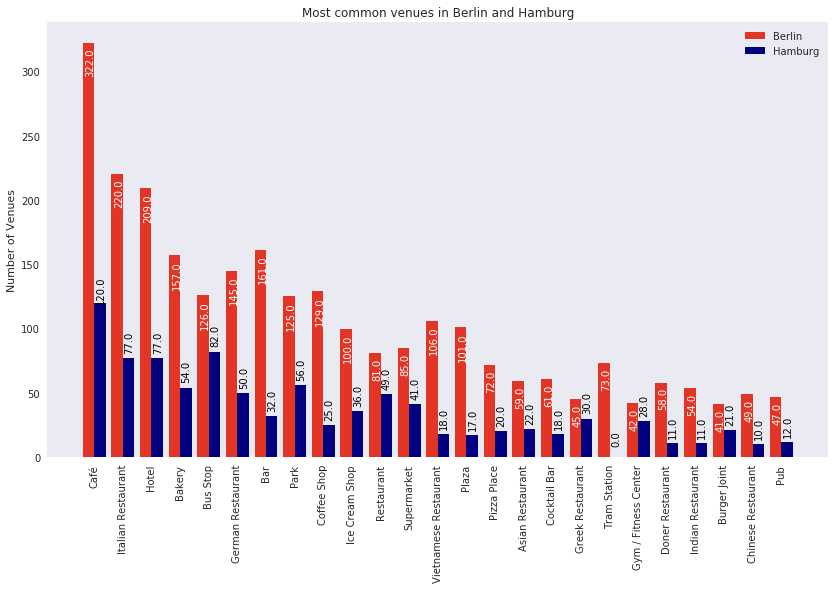

In [501]:
# counting returned venues per city
venue_count = onehot_BerHa.groupby('State').sum().reset_index()
venue_count.drop('Zipcode', axis = 1, inplace = True)
venue_count = venue_count.set_index('State').transpose()
venue_count['Total'] = venue_count.sum(axis=1)
venue_count.sort_values(by = ['Total'], inplace = True, ascending = False)

#filter for top 25 venues and sort
venue_count_top25 = venue_count.head(25)
print(venue_count_top25.shape)
venue_count_top25.reset_index(inplace = True)
venue_count_top25.columns = ['Venue', 'Berlin', 'Hamburg', 'Total']

#visualize top 25 venues
X = np.arange(25)
width = 0.4

plt.figure(figsize=(14,8), facecolor = 'white')

plt.bar(X + 0.00, venue_count_top25['Berlin'], color = '#e23525', width = width)
plt.bar(X + width, venue_count_top25['Hamburg'], color = '#000080', width = width)

plt.ylabel('Number of Venues')
plt.title('Most common venues in Berlin and Hamburg')

for s, d in zip(X, venue_count_top25['Berlin']):
    plt.annotate(venue_count_top25.Berlin[s], xy = (s-0.1,d-10), rotation=90, color='white')
for s, d in zip(X, venue_count_top25['Hamburg']):
    plt.annotate(venue_count_top25.Hamburg[s], xy = (s+0.25,d+15), rotation=90, color='black')

plt.xticks(X + width / 2, venue_count_top25['Venue'], rotation='vertical')
plt.legend(labels=venue_count_top25.columns[1:3], loc='best')

plt.show()

Berlin is roughly twice the size (which the number of ZIP-codes confirm: Hamburg = 101, Berlin = 195), therefore it is not surprising that more venues are returned overall. Yet it's intriguing that most venues of the Top25 most common types are at least 3x as often returned for Berlin. Further, some aspects should be mentioned:
* **cafés** leading the list as the most common venue type. This could be expected, as **restaurants** are split into sub-categories (e.g. by type of food). Interestingly tough, just the 'Italien Restaurants' alone manage to be the third highest counted venue type.
* Berlin areas returned 5 times as many **bars** as Hamburg, which can be due to the many times higher number of tourists in Berlin. Also, it is said that people from Berlin are more outgoing. Still the difference surprises, as Hamburg is place of the (in)famous Reeperbahn.
* Same might go for the difference in **coffee shops** and **ice cream places**. But there is propably only so much coffee one can drink and ice cream one can eat...
* comparing the number of **restaurans** is difficult, as some are not specified when it comes to their cuisine. Therefore I don't want to draw any conclusions to the differences in their numbers.
* The number of **gyms / fitness center** is unexpected high for Hamburg. Maybe this is connected to the higher number of rainy days in Hamburg, but maybe Hamburg residents are just fitter. ;)
* Yes, there are **train stations** and subway stations in Hamburg, but no tram stations. These are the once counted for Berlin.

For a better comparison though, we should look at those numbers when normalized with the number of inhabitants of both cities.

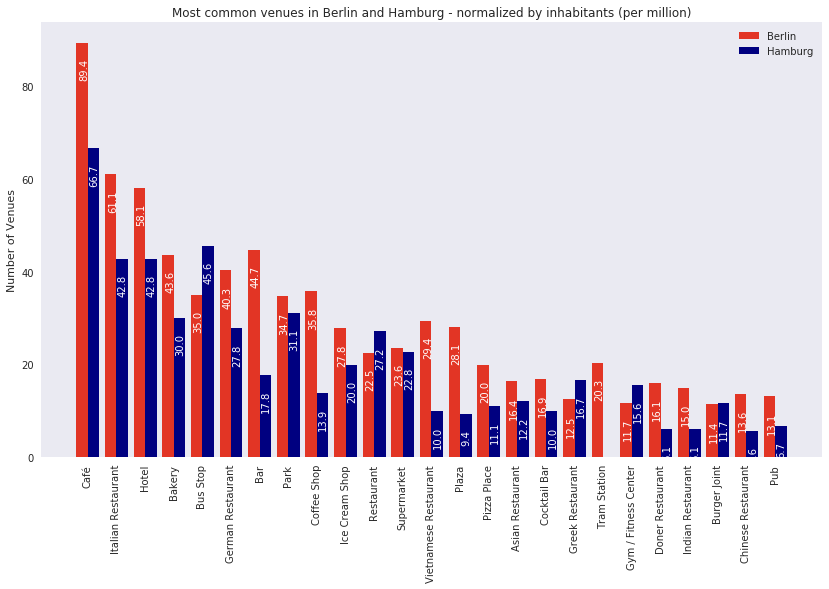

In [502]:
#data needs to be normalized based on inhabitans (Berlin ~ 3.6 mil, Hamburg ~ 1.8) 
venue_count_ntop25 = venue_count_top25.copy()
venue_count_ntop25['Berlin'] = venue_count_top25['Berlin'] / 3.6
venue_count_ntop25['Hamburg'] = venue_count_top25['Hamburg'] / 1.8
venue_count_ntop25 = venue_count_ntop25.round(1)

#visualize top 25 venues using normalized data
X = np.arange(25)
width = 0.4

plt.figure(figsize=(14,8))

plt.bar(X + 0.00, venue_count_ntop25['Berlin'], color = '#e23525', width = width)
plt.bar(X + width, venue_count_ntop25['Hamburg'], color = '#000080', width = width)

plt.ylabel('Number of Venues')
plt.title('Most common venues in Berlin and Hamburg - normalized by inhabitants (per million)')

for s, d in zip(X, venue_count_ntop25['Berlin']):
    plt.annotate(venue_count_ntop25.Berlin[s], xy = (s-0.1,d-5), rotation=90, color='white')
for s, d in zip(X, venue_count_ntop25['Hamburg']):
    plt.annotate(venue_count_ntop25.Hamburg[s], xy = (s+0.25,d-5), rotation=90, color='white')

plt.xticks(X + width / 2, venue_count_ntop25['Venue'], rotation='vertical')
plt.legend(labels=venue_count_ntop25.columns[1:3], loc='best')

plt.show()

Normalization of the data confirms, that Berlin has more venues per residents for the most common 25 venue categories. It also confirms the initial annotations about bars and coffe shops, which occur exceptionally often in Berlin.
Furthermore, the high amount of bus stops per residents in Hamburg seem to make up for the missing tram stations. Last but not least, it verifies that gym / fitness center are more common in Hamburg than in Berlin when comparing both cities based on nomarlized data.

In [394]:
#group rows by ZIP-code and by taking the mean of the frequency of occurrence of each category
grouped_BerHa = onehot_BerHa.groupby('Zipcode').mean().reset_index()
print(f'Shape: {grouped_BerHa.shape}')

Shape: (295, 435)


---------
##### Clustering
The final data frame is used for analysis of the ZIP-codes: clustering in order to find similarity in areas from Hamburg and Berlin.

Clustering is used for segmentation of the different ZIP-codes and is one of the unsupervised mashine learning methods. Each cluster is a group of objects (i.e. ZIP-code) that are similar to other objects in the cluster, and dissimilar to data points in other clusters.

For this analysis k-Means clustering is used. k-Means is a type of partition-based clustering in order to partitioning the data base into groups of individuals with similar characteristics. It divides data into non-overlapping subsets (clusters) without any cluster-internal structure. k-Means tries to minimize intra-cluster distances (e.g. Euclidean or other methods for measuring of distance) and maximize inter-cluster distances. It is an iterative algorithm, but the results depend on the initial defined number of clusters. In turn, this means that results (i.e. clusters) are guaranteed, but may be the optimum. Therefore, the algorithm will be run several times with different amount of initialy defined clusters.
The algorythm returns inertia, or cost, which can be recognized as a measure of how internally coherent clusters are.

In [511]:
#find best k

clustering_BerHa = grouped_BerHa.drop('Zipcode', 1)

best_k = []
for k in range (1, 25):
 
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(clustering_BerHa.iloc[:, :])

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = kmeans_model.labels_

    # Sum of distances of samples to their closest cluster center
    interia = kmeans_model.inertia_
    best_k.append([k,interia])
    print ("k:",k, " cost:", interia)
best_k = pd.DataFrame(best_k)
best_k.columns = ['k', 'Cost']
best_k

k: 1  cost: 20.229474794090613
k: 2  cost: 17.63966333617999
k: 3  cost: 16.821155379094986
k: 4  cost: 16.20174722779509
k: 5  cost: 15.8079314212539
k: 6  cost: 15.489365587356637
k: 7  cost: 15.035108680703217
k: 8  cost: 14.888216492140796
k: 9  cost: 14.422080758677982
k: 10  cost: 14.151217155219104
k: 11  cost: 13.966246174847685
k: 12  cost: 13.71552156111989
k: 13  cost: 13.376359303642564
k: 14  cost: 13.137031609164442
k: 15  cost: 12.852050168630818
k: 16  cost: 12.734680902021159
k: 17  cost: 12.466003947377176
k: 18  cost: 12.323994306288792
k: 19  cost: 12.093077777095337
k: 20  cost: 12.023315437506623
k: 21  cost: 11.766122968945607
k: 22  cost: 11.596717424262504
k: 23  cost: 11.343006403804331
k: 24  cost: 11.31979209312488


,k,Cost
0,1,20.229475
1,2,17.639663
2,3,16.821155
3,4,16.201747
4,5,15.807931
5,6,15.489366
6,7,15.035109
7,8,14.888216
8,9,14.422081
9,10,14.151217


The problem with k-Means: increasing k always reduces inertia / cost. Therefore, the value of cost as a function of k is plotted and an 'elbow' point is determined where the rate of decrease sharply shifts. This is selected as the right k for clustering ( elbow method).

<function matplotlib.pyplot.show(*args, **kw)>

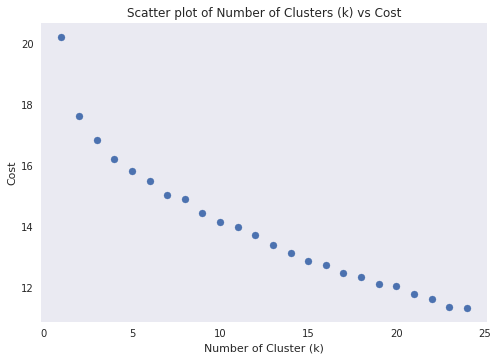

In [513]:
#plot cost values of k's as calculated above, to find best k value ('elbow')
plt.scatter(best_k['k'],best_k['Cost'])
plt.title("Scatter plot of Number of Clusters (k) vs Cost")
plt.ylabel("Cost")
plt.xlabel("Number of Cluster (k)")
plt.show

In [519]:
#cluster ZIP-codes by best k (lowest cost as calculated above, but at the same time fitting the data - see 'elbow' of line plot)
# best k value is set at 15, which is reasonable comparing 295 areas with each other
# set number of clusters
kclusters = 15

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering_BerHa)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([ 8,  8,  8,  8,  8,  8,  7,  7, 10,  5], dtype=int32)

In [520]:
#First write a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#create the new dataframe and display the top 10 venues for each ZIP-code
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zipcode_BerHa_venues_sorted = pd.DataFrame(columns=columns)
zipcode_BerHa_venues_sorted['Zipcode'] = grouped_BerHa['Zipcode']

for ind in np.arange(grouped_BerHa.shape[0]):
    zipcode_BerHa_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped_BerHa.iloc[ind, :], num_top_venues)

#new dataframe that includes the cluster as well as the top 10 venues for each ZIP-code
# add clustering labels
zipcode_BerHa_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

merged_BerHa = zipcode_BerHa

# merge toronto_grouped with toronto_data to add latitude/longitude for each ZIP-code
merged_BerHa = merged_BerHa.join(zipcode_BerHa_venues_sorted.set_index('Zipcode'), on='zipcode')

merged_clean_BerHa = merged_BerHa.dropna(subset=['Cluster Labels'], axis = 0, inplace = False)
merged_clean_BerHa = merged_clean_BerHa.astype({'Cluster Labels': int})

print(f'Shape Berlin & Hamburg: {merged_clean_BerHa.shape}')
merged_clean_BerHa.head()

Shape Berlin & Hamburg: (295, 15)


,zipcode,state,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10115,Berlin,52.5323,13.3846,8,Coffee Shop,Restaurant,Hotel,Italian Restaurant,Pub,Falafel Restaurant,Café,Modern European Restaurant,French Restaurant,Bakery
1,10117,Berlin,52.5170,13.3872,8,Hotel,German Restaurant,Café,Concert Hall,Vegetarian / Vegan Restaurant,Monument / Landmark,Gourmet Shop,Theater,Restaurant,Wine Bar
2,10119,Berlin,52.5305,13.4053,8,Italian Restaurant,Coffee Shop,Vietnamese Restaurant,Hotel,Café,Bookstore,Ice Cream Shop,Bar,Beer Bar,Vegetarian / Vegan Restaurant
3,10178,Berlin,52.5213,13.4096,8,Hotel,Vietnamese Restaurant,Coffee Shop,Clothing Store,Café,Plaza,Ice Cream Shop,Indie Movie Theater,Optical Shop,Bookstore
4,10179,Berlin,52.5122,13.4164,8,Hotel,Nightclub,Café,German Restaurant,Bistro,Restaurant,Museum,Bakery,History Museum,Outdoor Supply Store


In [2]:
#Use geopy library to get the latitude and longitude values of Berlin and Hamburg

address_Ber = 'Berlin'

geolocator_Ber = Nominatim(user_agent="ber_explorer")
location_Ber = geolocator_Ber.geocode(address_Ber)
latitude_Ber = location_Ber.latitude
longitude_Ber = location_Ber.longitude
print(f'The geographical coordinate of Berlin are {latitude_Ber}, {longitude_Ber}.')


address_Ha = 'Hamburg'

geolocator_Ha = Nominatim(user_agent="ha_explorer")
location_Ha = geolocator_Ha.geocode(address_Ha)
latitude_Ha = location_Ha.latitude
longitude_Ha = location_Ha.longitude
print(f'The geographical coordinate of Hamburg are {latitude_Ha}, {longitude_Ha}.')

latitude_mid = (latitude_Ha + latitude_Ber) / 2
longitude_mid = (longitude_Ha + longitude_Ber) / 2

print(f'The geographical middle between both cities is: {latitude_mid}, {longitude_mid}')

NameError: name 'Nominatim' is not defined

In [521]:
# create map for Berlin
map_BerHa_clusters = folium.Map(location=[latitude_mid, longitude_mid], zoom_start=8.3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_clean_BerHa['latitude'], merged_clean_BerHa['longitude'], merged_clean_BerHa['zipcode'], merged_clean_BerHa['Cluster Labels']): #for clustering add cluster here
    label = folium.Popup('ZIP-code: ' + str(poi) + ' -- Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_BerHa_clusters)
       
map_BerHa_clusters

In [522]:
#show number of ZIP-codes per cluster
merged_clean_BerHa.sort_values(by = ['Cluster Labels'], inplace = True)
cluster_count = merged_clean_BerHa['Cluster Labels'].value_counts()
cluster_count = pd.DataFrame(cluster_count).reset_index()
cluster_count.columns = ['Cluster','ZIP-codes']
cluster_count.sort_values(by = 'Cluster')

,Cluster,ZIP-codes
7,0,12
5,1,27
12,2,2
1,3,50
6,4,14
4,5,27
11,6,2
0,7,61
3,8,35
9,9,5


##### Conclusion:
As can be seen, there are certain cluster that more common and some that are unique or seldom. This result can be expected, as some neighborhoods share a common cause, e.g. housing. These neighborhoods fall into the same cluster as they share a similar venue structure. Purple (cluster 1), dark blue (cluster 3), navy blue (cluster 4) and light blue (cluster 5) could fall into this category. They are distributed around the city center in a circular manner.

At the same time, neighborhoods located at the center of both cities share similar trades too, within the same city and across both cities (e.g. turquoise - cluster 7, light turquoise - cluster 8 and light green - cluster 10). These are more venue crowded neighborhoods. This also seems to apply to areas on the outskirts of the city: light and dark orange (cluster 11 and 13 respectively) as well as red (cluster 0).

To get deeper insights into what makes each cluster different, check out the full table below. Thanks a lot for reading, all Feedback, ideas and comments are much appreciated.

In [1]:
merged_clean_BerHa.head(100)

NameError: name 'merged_clean_BerHa' is not defined